In [37]:
%matplotlib inline
%pwd

'/home/gabe/work/fast-ai/nbs'

In [38]:
%%html
<style>
  .end_space {
      min-height: 1000px;
  }
  .container {
      width: 100%;
  }
</style

In [39]:
import sys
import os
import tarfile
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy

from scipy.ndimage.interpolation import shift
from pandas.plotting import scatter_matrix
from six.moves import urllib
from importlib import reload
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from os import listdir, makedirs
from os.path import join, abspath, exists, isdir, isfile

SEED=42

np.random.seed(seed=SEED)
sys.path.append('../src')

In [40]:
import utils.utils
reload(utils.utils)

import utils.train_helper
reload(utils.train_helper)

import utils.mix_iterator
reload(utils.mix_iterator)

import utils.housing_helper
reload(utils.housing_helper)

from utils.train_helper import save_model, read_model, get_classes, get_batches, get_data, un_onehot
from utils.utils import save_array, load_array, read_img, get_steps, do_clip, mkdir
from utils.mix_iterator import MixIterator
from utils.housing_helper import CombinedAttributesAdder, DataFrameSelector, CategoricalEncoder

In [41]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam, Nadam
from keras.regularizers import l2
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import xception, inception_v3
from keras.utils import to_categorical as onehot

from sklearn import datasets
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier, SGDRegressor, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error, confusion_matrix, precision_score
from sklearn.metrics import precision_recall_curve, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.externals import joblib
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR

In [42]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

In [43]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

In [49]:
from sklearn.tree import export_graphviz

def export_tree(tree_clf, out_file):
    """
    Export a tree to graphviz format
    Convert to other formats using graphviz
    > dot -Tpng tree.dot -o tree.png
    """
    export_graphviz(tree_clf,
                    out_file=out_file,
                    feature_names=iris.feature_names[2:],
                    class_names=iris.target_names,
                    rounded=True,
                    filled=True)

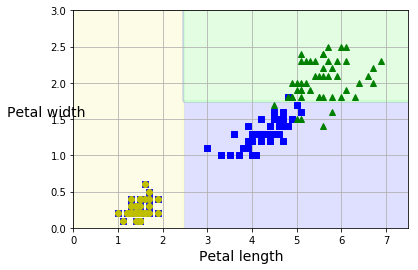

In [45]:
iris = datasets.load_iris()
X = iris.data[:, 2:]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

axes=[0, 7.5, 0, 3]
plot_dataset(X, y, axes)
plot_decision_boundary(tree_clf, X, y, axes)